In [2]:
import pandas as pd
import torch
import torch_directml
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
import multiprocessing as mp
from multiprocessing import Array

In [4]:
# Load your preprocessed dataset
data1 = pd.read_csv('D:/Data/kcc_dataset.csv')
print(data1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_41744\2604830758.py:2: DtypeWarning: Columns (1,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('D:/Data/kcc_dataset.csv')


            BlockName Category  Year  Month  Day        Crop  \
0                0           0  2006      1   17        1275   
1                0           0  2006      1   17         964   
2                0           0  2006      1   17        1279   
3                0           0  2006      1   17        1064   
4                0           0  2006      1   17        1279   
...               ...      ...   ...    ...  ...         ...   
37962920        DELHI   Others  2023     10   13      Others   
37962921    TLANGNUAM   Others  2023     10   13      Others   
37962922    TLANGNUAM   Others  2023     10   13      Others   
37962923      DARLAWN   Others  2023     10   13      Others   
37962924  Thirunallar  Cereals  2023     10   13  Paddy Dhan   

                       DistrictName           QueryType Season  \
0                             SAGAR                  99   RABI   
1                             SAGAR  Disease Management   RABI   
2                             SAG

In [5]:
# Filter the dataset
f_df = data1[(data1['Crop'].str.isnumeric() == False) & (data1['Crop'] != 'Others') & 
             (data1['QueryType'].str.isnumeric() == False) & (data1['QueryType'] != 'Others')]
df= pd.DataFrame(f_df)
df = df[df['Year'] >= 2013]
# Create a new feature 'Crop_QueryType'
df["place"] = df['StateName'] + '_' + df['DistrictName']
data = df[['Month', 'Year', 'place', 'Crop', 'QueryType']]


CROP-WISE QUERYTYPE TRAINING

In [6]:
# Encode QueryType as categorical variable
data['QueryType_code'] = data['QueryType'].astype('category').cat.codes

# Prepare input texts by using DistrictName and Crop_QueryType
data['text'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop']} {row['QueryType']}", axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_41744\1181383426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['QueryType_code'] = data['QueryType'].astype('category').cat.codes
C:\Users\Admin\AppData\Local\Temp\ipykernel_41744\1181383426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop']} {row['QueryType']}", axis=1)


In [7]:
# Tokenize the text inputs
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
inputs = tokenizer(data['text'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Extract labels for training (Crop_QueryType codes)
labels = torch.tensor(data['QueryType_code'].values, dtype=torch.long)

In [8]:
# Split the dataset into training and testing sets
train_inputs, test_inputs, train_labels, test_labels, train_idx, test_idx = train_test_split(
    inputs['input_ids'], labels, data.index, test_size=0.2, random_state=42)
train_masks, test_masks = train_test_split(inputs['attention_mask'], test_size=0.2, random_state=42)

In [9]:
# Create DataLoader for training and validation
batch_size = 16

train_data = TensorDataset(train_inputs, torch.tensor(train_masks), train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, torch.tensor(test_masks), test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

C:\Users\Admin\AppData\Local\Temp\ipykernel_41744\3377841694.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = TensorDataset(train_inputs, torch.tensor(train_masks), train_labels)
C:\Users\Admin\AppData\Local\Temp\ipykernel_41744\3377841694.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = TensorDataset(test_inputs, torch.tensor(test_masks), test_labels)


In [10]:
# Initialize the model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=data['QueryType_code'].nunique())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [11]:
# Set up the optimizer and loss function
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()

c:\Users\Admin\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Compute the loss
        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()

        # Backward pass and update
        loss.backward()
        optimizer.step()

        if step % 1000 == 0:
            print(f"Epoch {epoch + 1}/{epochs} | Step {step}/{len(train_dataloader)} | Loss: {loss.item()}")

    # End time for the epoch
    epoch_end_time = time.time()
    
    # Calculate average loss and time taken for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    epoch_time = epoch_end_time - epoch_start_time
    
    print(f"Epoch {epoch + 1}, Average Loss: {avg_train_loss}, Time Taken: {epoch_time:.2f} seconds")
    

c:\Users\Admin\anaconda3\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/1 | Step 0/839071 | Loss: 4.115621089935303
Epoch 1/1 | Step 1000/839071 | Loss: 0.0920330062508583
Epoch 1/1 | Step 2000/839071 | Loss: 0.005906142294406891
Epoch 1/1 | Step 3000/839071 | Loss: 0.0018234231974929571
Epoch 1/1 | Step 4000/839071 | Loss: 0.0014383802190423012
Epoch 1/1 | Step 5000/839071 | Loss: 0.0004411045811139047
Epoch 1/1 | Step 6000/839071 | Loss: 0.0019014236750081182
Epoch 1/1 | Step 7000/839071 | Loss: 0.003261815058067441
Epoch 1/1 | Step 8000/839071 | Loss: 0.0006131986156105995
Epoch 1/1 | Step 9000/839071 | Loss: 0.0002484227588865906
Epoch 1/1 | Step 10000/839071 | Loss: 8.632714161649346e-05
Epoch 1/1 | Step 11000/839071 | Loss: 0.00021728103456553072
Epoch 1/1 | Step 12000/839071 | Loss: 5.888478335691616e-05
Epoch 1/1 | Step 13000/839071 | Loss: 9.625859092921019e-05
Epoch 1/1 | Step 14000/839071 | Loss: 2.754395427473355e-05
Epoch 1/1 | Step 15000/839071 | Loss: 9.639735071687028e-05
Epoch 1/1 | Step 16000/839071 | Loss: 4.84245756524615e-05
Ep

KeyboardInterrupt: 

In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask = b_input_ids.to(device), b_input_mask.to(device)
        
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

In [ ]:
# After prediction, use test_idx to reference the original data
predictions_flat = predictions

# Use the indices from test_idx to retrieve the original Month and DistrictName from the original data
predicted_data = pd.DataFrame({
    'Month': data.loc[test_idx, 'Month'].values, 
    'Place': data.loc[test_idx, 'place'].values,
    'Crop' : data.loc[test_idx, 'Crop'].values,
    'QueryType_code': predictions_flat
})
print(predicted_data)

In [ ]:
data['QueryType'] = data['QueryType'].astype('category')
predicted_data['QueryType']=predicted_data['QueryType_code'].apply(lambda x: data['QueryType'].cat.categories[x])
print(predicted_data)

In [ ]:
# Predict most frequent Crop_QueryType for next year on a monthly basis
monthly_predictions = predicted_data.groupby(['Month', 'Place', 'Crop'])['QueryType'].apply(lambda x: x.value_counts().index[:10]).reset_index()
print(monthly_predictions)

In [ ]:
monthly_predictions= monthly_predictions.explode('QueryType')
# Concatenate the QueryType values for each unique combination of Month and Place
monthly_predictions = monthly_predictions.groupby(['Month', 'Place','Crop'])['QueryType'].apply(lambda x: ', '.join(x)).reset_index()

# Save predictions to CSV with only Month, Place, and Crop_QueryType columns
monthly_predictions[['Month', 'Place','Crop','QueryType']].to_csv('D:/Data/Top_predicted_cropwise_querytypes_in_India_111.csv', index=False, header=True)

In [ ]:
# Flatten the predictions and true labels
predictions = np.array(predictions)
true_labels = np.array(true_labels)

In [ ]:

def rmse(true_labels, predictions):
    return np.sqrt(np.mean((np.array(true_labels) - np.array(predictions)) ** 2))

def mae(true_labels, predictions):
    return np.mean(np.abs(np.array(true_labels) - np.array(predictions)))

def f1_score(true_labels, predictions):
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    # Calculate F1-Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1

def recall(true_labels, predictions):
    # Calculate True Positives (TP) and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return recall

In [ ]:
# Calculate RMSE and MAE
rmse = rmse(true_labels, predictions)
mae = mae(true_labels, predictions)

# Calculate F1-Score and Recall
f1 = f1_score(true_labels, predictions)
recall = recall(true_labels, predictions)

accuracy= accuracy(true_labels, predictions)
precision= precision(true_labels, predictions)


In [ ]:
# Create a bar plot for the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE']
values = [accuracy, precision, recall, f1, rsme, mae]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'Teal', 'orange'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Display the metrics in a tabular format
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE'],
    'Value': [accuracy, precision, recall, f1, rsme, mae]
})

print("\nModel Performance Metrics:")
print(metrics_table)

# Save the metrics to a CSV file
metrics_table.to_csv('D:/Data/roberts1_model_performance_metrics.csv', index=False)


CROP-QUERYTYPE TRAINING

In [13]:
df["Crop_QueryType"] = df["Crop"] + "_" +df["QueryType"]
data=df[['Month','place','Crop_QueryType']]

print(data)
# Encode Crop_QueryType as categorical variable
data['Crop_QueryType_code'] = data['Crop_QueryType'].astype('category').cat.codes

          Month                            place  \
3039763       1        ANDHRA PRADESH_SRIKAKULAM   
3039867       2        ANDHRA PRADESH_SRIKAKULAM   
3039869       2        ANDHRA PRADESH_SRIKAKULAM   
3040001       4        ANDHRA PRADESH_SRIKAKULAM   
3040002       4        ANDHRA PRADESH_SRIKAKULAM   
...         ...                              ...   
37962914     10  DELHI_New Delhi Connaught Place   
37962916     10  DELHI_New Delhi Connaught Place   
37962917     10  DELHI_New Delhi Connaught Place   
37962919     10  DELHI_New Delhi Connaught Place   
37962924     10              PUDUCHERRY_KARAIKAL   

                                             Crop_QueryType  
3039763               Sunflower suryamukhi_Water Management  
3039867   Groundnut pea nutmung phalli_Fertilizer Use an...  
3039869   Groundnut pea nutmung phalli_Fertilizer Use an...  
3040001                        Runner Bean_Plant Protection  
3040002                            Coconut_Plant Protection  
...

C:\Users\Admin\AppData\Local\Temp\ipykernel_41744\3142573208.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crop_QueryType_code'] = data['Crop_QueryType'].astype('category').cat.codes


In [14]:
# Prepare input texts by using DistrictName and Crop_QueryType
data['text1'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop_QueryType']}", axis=1)


C:\Users\Admin\AppData\Local\Temp\ipykernel_41744\2514243442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text1'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop_QueryType']}", axis=1)


In [15]:
# Tokenize the text inputs
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
inputs1 = tokenizer(data['text1'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Extract labels for training (Crop_QueryType codes)
labels1 = torch.tensor(data['Crop_QueryType_code'].values, dtype=torch.long)


In [16]:
# Split the data without stratification
train_inputs1, test_inputs1, train_labels1, test_labels1, train_idx1, test_idx1 = train_test_split(
    inputs1['input_ids'], labels1, data.index, test_size=0.2, random_state=42)


In [17]:
# Continue as normal with train and test sets
train_masks1, test_masks1 = train_test_split(inputs1['attention_mask'], test_size=0.2, random_state=42)

In [18]:
# Create DataLoader for training and validation
batch_size = 16

train_data1 = TensorDataset(train_inputs1, torch.tensor(train_masks1), train_labels1)
train_sampler1 = RandomSampler(train_data1)
train_dataloader1 = DataLoader(train_data1, sampler=train_sampler1, batch_size=batch_size)

test_data1 = TensorDataset(test_inputs1, torch.tensor(test_masks1), test_labels1)
test_sampler1 = SequentialSampler(test_data1)
test_dataloader1 = DataLoader(test_data1, sampler=test_sampler1, batch_size=batch_size)

C:\Users\Admin\AppData\Local\Temp\ipykernel_41744\419209612.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data1 = TensorDataset(train_inputs1, torch.tensor(train_masks1), train_labels1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_41744\419209612.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data1 = TensorDataset(test_inputs1, torch.tensor(test_masks1), test_labels1)


In [19]:
# Initialize the model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=data['Crop_QueryType_code'].nunique())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [20]:
# Set up the optimizer and loss function
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()

c:\Users\Admin\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader1):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Compute the loss
        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()

        # Backward pass and update
        loss.backward()
        optimizer.step()

        if step % 1000 == 0:
            print(f"Epoch {epoch + 1}/{epochs} | Step {step}/{len(train_dataloader)} | Loss: {loss.item()}")

    # End time for the epoch
    # epoch_end_time = time.time()
    
    # Calculate average loss and time taken for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    # epoch_time = epoch_end_time - epoch_start_time
    
    print(f"Epoch {epoch + 1}, Average Loss: {avg_train_loss}") 
          # Time Taken: {epoch_time:.2f} seconds")
    


Epoch 1/1 | Step 0/839071 | Loss: 8.96476936340332
Epoch 1/1 | Step 1000/839071 | Loss: 3.105717420578003
Epoch 1/1 | Step 2000/839071 | Loss: 2.4748892784118652
Epoch 1/1 | Step 3000/839071 | Loss: 1.6189265251159668
Epoch 1/1 | Step 4000/839071 | Loss: 1.269652009010315
Epoch 1/1 | Step 5000/839071 | Loss: 0.4091491997241974
Epoch 1/1 | Step 6000/839071 | Loss: 0.5361371636390686
Epoch 1/1 | Step 7000/839071 | Loss: 0.34057489037513733
Epoch 1/1 | Step 8000/839071 | Loss: 0.5223244428634644
Epoch 1/1 | Step 9000/839071 | Loss: 1.172743558883667
Epoch 1/1 | Step 10000/839071 | Loss: 0.4117088317871094
Epoch 1/1 | Step 11000/839071 | Loss: 1.5317280292510986
Epoch 1/1 | Step 12000/839071 | Loss: 0.2253333181142807
Epoch 1/1 | Step 13000/839071 | Loss: 0.5722909569740295
Epoch 1/1 | Step 14000/839071 | Loss: 0.769890546798706
Epoch 1/1 | Step 15000/839071 | Loss: 0.020391954109072685
Epoch 1/1 | Step 16000/839071 | Loss: 0.13320358097553253
Epoch 1/1 | Step 17000/839071 | Loss: 0.020931

In [ ]:
    avg_train_loss = total_loss / len(train_dataloader)
    # epoch_time = epoch_end_time - epoch_start_time
    
    print(f"Epoch {epoch + 1}, Average Loss: {avg_train_loss}")#

In [22]:
# Evaluation
model.eval()
predictions1 = []
true_labels1 = []
with torch.no_grad():
    for batch in test_dataloader1:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask = b_input_ids.to(device), b_input_mask.to(device)
        
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions1.extend(preds)
        true_labels1.extend(b_labels.cpu().numpy()) 

In [23]:
# After prediction, use test_idx to reference the original data
predictions_flat1 = predictions1

# Use the indices from test_idx to retrieve the original Month and DistrictName from the original data
predicted_data1= pd.DataFrame({
    'Month': data.loc[test_idx1, 'Month'].values, 
    'Place': data.loc[test_idx1, 'place'].values,
    'Crop_QueryType_code': predictions_flat1
})
print(predicted_data1)

         Month                   Place  Crop_QueryType_code
0            2    TELANGANA_SANGAREDDY                 5468
1            7     MAHARASHTRA_SOLAPUR                 1885
2           10         HARYANA_JHAJJAR                 7763
3            7    UTTAR PRADESH_JALAUN                 1353
4            4     WEST BENGAL_BANKURA                 7433
...        ...                     ...                  ...
3356277      7        RAJASTHAN_JAIPUR                 5662
3356278     10  MAHARASHTRA_AHMADNAGAR                  864
3356279      8       KARNATAKA_BELLARY                 4973
3356280     10         RAJASTHAN_ALWAR                 2331
3356281      1            ASSAM_NAGAON                 2181

[3356282 rows x 3 columns]


In [24]:
data['Crop_QueryType'] = data['Crop_QueryType'].astype('category')
predicted_data1['Crop_QueryType']=predicted_data1['Crop_QueryType_code'].apply(lambda x: data['Crop_QueryType'].cat.categories[x])
print(predicted_data1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_41744\301140935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crop_QueryType'] = data['Crop_QueryType'].astype('category')


         Month                   Place  Crop_QueryType_code  \
0            2    TELANGANA_SANGAREDDY                 5468   
1            7     MAHARASHTRA_SOLAPUR                 1885   
2           10         HARYANA_JHAJJAR                 7763   
3            7    UTTAR PRADESH_JALAUN                 1353   
4            4     WEST BENGAL_BANKURA                 7433   
...        ...                     ...                  ...   
3356277      7        RAJASTHAN_JAIPUR                 5662   
3356278     10  MAHARASHTRA_AHMADNAGAR                  864   
3356279      8       KARNATAKA_BELLARY                 4973   
3356280     10         RAJASTHAN_ALWAR                 2331   
3356281      1            ASSAM_NAGAON                 2181   

                                            Crop_QueryType  
0                              Paddy Dhan_Plant Protection  
1                                Chillies_Plant Protection  
2                            Wheat_Sowing Time and Weather  

In [25]:
# Predict most frequent Crop_QueryType for next year on a monthly basis
monthly_predictions1 = predicted_data1.groupby(['Month', 'Place'])['Crop_QueryType'].apply(lambda x: x.value_counts().index[:15]).reset_index()
print(monthly_predictions1)

      Month                          Place  \
0         1        A AND N ISLANDS_NICOBAR   
1         1        ANDHRA PRADESH_ANANTPUR   
2         1        ANDHRA PRADESH_CHITTOOR   
3         1   ANDHRA PRADESH_EAST GODAVARI   
4         1          ANDHRA PRADESH_GUNTUR   
...     ...                            ...   
7741     12     WEST BENGAL_North DINAJPUR   
7742     12            WEST BENGAL_PURULIA   
7743     12  WEST BENGAL_SOUTH 24 PARGANAS   
7744     12     WEST BENGAL_South DINAJPUR   
7745     12     WEST BENGAL_WEST MEDINIPUR   

                                         Crop_QueryType  
0     Index(['Sugarcane Noble Cane_Plant Protection'...  
1     Index(['Groundnut pea nutmung phalli_Plant Pro...  
2     Index(['Paddy Dhan_Plant Protection', 'Chillie...  
3     Index(['Paddy Dhan_Plant Protection', 'Chillie...  
4     Index(['Chillies_Plant Protection', 'Chillies_...  
...                                                 ...  
7741  Index(['Potato_Plant Protection', '

In [26]:
monthly_predictions1= monthly_predictions1.explode('Crop_QueryType')
# Concatenate the QueryType values for each unique combination of Month and Place
monthly_predictions1 = monthly_predictions1.groupby(['Month', 'Place'])['Crop_QueryType'].apply(lambda x: ', '.join(x)).reset_index()
print(monthly_predictions1)

      Month                          Place  \
0         1        A AND N ISLANDS_NICOBAR   
1         1        ANDHRA PRADESH_ANANTPUR   
2         1        ANDHRA PRADESH_CHITTOOR   
3         1   ANDHRA PRADESH_EAST GODAVARI   
4         1          ANDHRA PRADESH_GUNTUR   
...     ...                            ...   
7741     12     WEST BENGAL_North DINAJPUR   
7742     12            WEST BENGAL_PURULIA   
7743     12  WEST BENGAL_SOUTH 24 PARGANAS   
7744     12     WEST BENGAL_South DINAJPUR   
7745     12     WEST BENGAL_WEST MEDINIPUR   

                                         Crop_QueryType  
0     Sugarcane Noble Cane_Plant Protection, POULTRY...  
1     Groundnut pea nutmung phalli_Plant Protection,...  
2     Paddy Dhan_Plant Protection, Chillies_Plant Pr...  
3     Paddy Dhan_Plant Protection, Chillies_Plant Pr...  
4     Chillies_Plant Protection, Chillies_Nutrient M...  
...                                                 ...  
7741  Potato_Plant Protection, Maize Makk

In [27]:
# Predict most frequent Crop_QueryType for next year on a monthly basis
monthly_data1 = predicted_data1.groupby(['Month', 'Place'])['Crop_QueryType'].apply(lambda x: ', '.join(x)).reset_index()
print(monthly_data1)

      Month                          Place  \
0         1        A AND N ISLANDS_NICOBAR   
1         1        ANDHRA PRADESH_ANANTPUR   
2         1        ANDHRA PRADESH_CHITTOOR   
3         1   ANDHRA PRADESH_EAST GODAVARI   
4         1          ANDHRA PRADESH_GUNTUR   
...     ...                            ...   
7741     12     WEST BENGAL_North DINAJPUR   
7742     12            WEST BENGAL_PURULIA   
7743     12  WEST BENGAL_SOUTH 24 PARGANAS   
7744     12     WEST BENGAL_South DINAJPUR   
7745     12     WEST BENGAL_WEST MEDINIPUR   

                                         Crop_QueryType  
0     Sugarcane Noble Cane_Plant Protection, POULTRY...  
1     Pigeon pea red gramarhartur_Plant Protection, ...  
2     Mango_Plant Protection, Beans _Nutrient Manage...  
3     Paddy Dhan_Plant Protection, Maize Makka_Plant...  
4     Black Gram urd bean_Varieties, Chillies_Nutrie...  
...                                                 ...  
7741  Mustard_Nutrient Management, Cucumb

In [28]:
# Save predictions to CSV with only Month, Place, and Crop_QueryType columns
monthly_data1.to_csv('D:/Data/Places_crop_querytypes_in_India11.csv', index=False, header=True)

In [29]:
# Flatten the predictions and true labels
predictions1 = np.array(predictions1)
true_labels1 = np.array(true_labels1)

In [30]:

def rmse(true_labels, predictions):
    return np.sqrt(np.mean((np.array(true_labels) - np.array(predictions)) ** 2))

def mae(true_labels, predictions):
    return np.mean(np.abs(np.array(true_labels) - np.array(predictions)))

def f1_score(true_labels, predictions):
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    # Calculate F1-Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1

def recall(true_labels, predictions):
    # Calculate True Positives (TP) and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return recall

def precision(true_labels, predictions):
    # Calculate True Positives (TP) and False Positives (FP)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    
    # Calculate Precision
    return tp / (tp + fp) if (tp + fp) != 0 else 0

def accuracy(true_labels, predictions):
    # Count the number of correct predictions
    correct = np.sum(np.array(true_labels) == np.array(predictions))
    # Calculate accuracy
    return correct / len(true_labels)

In [31]:
# Calculate RMSE and MAE
rmse = rmse(true_labels1, predictions1)
mae = mae(true_labels1, predictions1)

# Calculate F1-Score and Recall
f1= f1_score(true_labels1, predictions1)
recall = recall(true_labels1, predictions1)

accuracy = accuracy(true_labels1, predictions1)
precision = precision(true_labels1, predictions1)

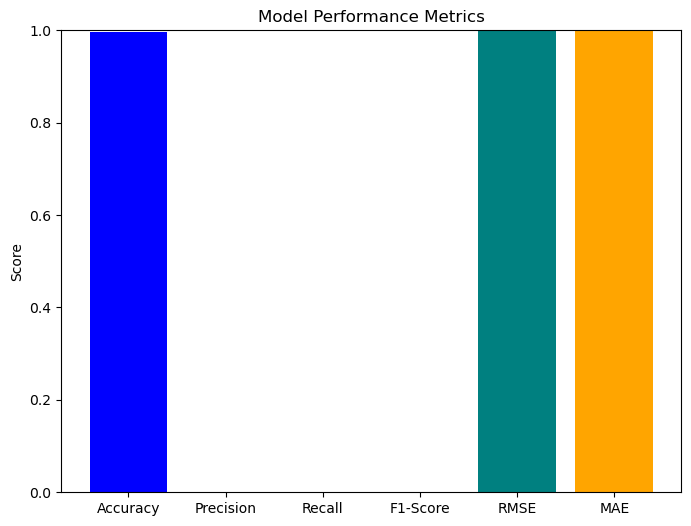


Model Performance Metrics:
      Metric       Value
0   Accuracy    0.996934
1  Precision    0.000000
2     Recall    0.000000
3   F1-Score    0.000000
4       RMSE  124.883257
5        MAE    4.056527


In [35]:
# Create a bar plot for the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE']
values = [accuracy, precision, recall, f1, rmse, mae]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'Teal', 'orange'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Display the metrics in a tabular format
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE'],
    'Value': [accuracy, precision, recall, f1, rmse, mae]
})

print("\nModel Performance Metrics:")
print(metrics_table)

# Save the metrics to a CSV file
metrics_table.to_csv('D:/Data/roberta2_model_performance_metrics.csv', index=False)

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
rmse = np.sqrt(mean_squared_error(true_labels1, predictions1))
print(rmse)

124.8832574519403
